# Exercice 4 : Méthodologie de validation croisée et test

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

Choix de la fonction à apprendre pour l'exemple : ici un polynome de degré 5.

In [2]:
listeParamPoly = [0.03, 0.2, -1, -10, 100]

In [3]:
def generate_data(N):
    x = np.random.uniform(-10,10,N)
    y = np.polyval(listeParamPoly,x) + np.random.normal(0.0, 15.0, N)
    return x.reshape(-1, 1), y

Fonction permettant de calculer les intervalles de confiance de notre métrique (ici la [MSE](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)):

In [4]:
def confidence_interval(y, y_pred):
    n = len(y)
    s = np.sqrt(np.var(mean_squared_error(np.expand_dims(y,1).transpose(), np.expand_dims(y_pred,1).transpose(),
                          multioutput='raw_values'), ddof=1))
    return 1.96*s/np.sqrt(n)

Génération des données : Choisir le nombre de points à utiliser :

In [5]:
dataPoints = 200

In [6]:
X,y = generate_data(dataPoints)

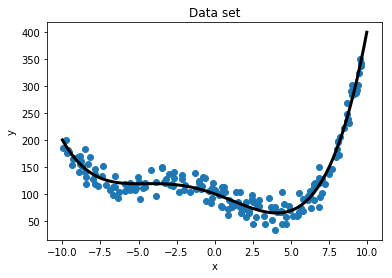

In [7]:
fig, ax = plt.subplots()
ax.plot(X, y, 'o')
ax.plot(np.linspace(-10,10,100), np.polyval(listeParamPoly,np.linspace(-10,10,100)), color='black', linewidth=3)
ax.set_title('Data set')
ax.set_ylabel('y')
ax.set_xlabel('x')
plt.show()

# Définition des fonctions de caractéristiques

Reprenez ici vos fonctions de caractéristiques de l'exercice précédent.

In [8]:
phi = [
       lambda x: x**0, 
       lambda x: x**1,
       lambda x: x**2,
       lambda x: x**3,
       lambda x: np.abs(x),
       lambda x: x > -5.0,
       lambda x: x > 0.0,
       lambda x: x > 5.0,
       lambda x: np.cos(0.1*x),
       lambda x: np.cos(x),
       lambda x: np.sin(0.1*x),
       lambda x: np.sin(x),
      ]

In [9]:
def feature_space_projection(X, phi):
    X_features = []
    for i in range(0, len(phi)):
        X_features.append(np.apply_along_axis(phi[i], 0, X))
    X_augmented = np.concatenate(X_features, axis=1)
    return X_augmented

# Préparation des données test
Après projection dans l'espace des caractéristiques nous découpons notre dataset en deux parties.

In [10]:
X_phi = feature_space_projection(X, phi)

### splits : train(75%) - test(25%)

Un ensemble d'entrainement sur lequel nous ferons de la validation croisée et un ensemble de test pour la vérification *finale*.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_phi, y, test_size=0.25)

# Cross-validation du modèle/hyperparamètres

Vous pouvez ici changez les hyper-paramètres pour en voir l'effet sur les différentes erreurs sur les différents sous-ensembles de données. Vous pouvez aussi essayer d'autres modèles linéaires.

In [12]:
reg2 = linear_model.ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='random', tol=0.0001, warm_start=False)

In [13]:
cv_score = cross_val_score(reg2, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

In [14]:
-cv_score

array([363.06977302, 245.98734128, 143.84119199, 224.67280701,
       248.11356021])

In [15]:
np.mean(-cv_score)

245.13693470087338

# Recherche en grille des hyperparamètres

Plutot que de rechercher *au jugé* les hyperparmètres, il est plus intéressant, quand c'est possible, de *tous* les essayer.

In [16]:
reg2 = linear_model.ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='random', tol=0.0001, warm_start=False)

Nous définissons donc ici, tous les couples d'hyperparmètres à utiliser.

In [17]:
hyperparameters = {'l1_ratio':[0.0, 0.25, 0.5, 0.75, 1.0], 'alpha':[0.01, 0.1, 1, 10, 100]}

In [18]:
clf = GridSearchCV(reg2, hyperparameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [19]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 110 out of 125 | elapsed:    9.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   13.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='random', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0], 'alpha': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [20]:
clf.best_params_

{'alpha': 0.1, 'l1_ratio': 1.0}

Curieusement, quand on voit les résultats des *meilleurs* hyperparmètres, l'envie de raffiner votre grille de recherche dans la bonne région se fait probalement sentir ...

# Entraînement et évaluation sur le test

Une fois les meilleurs hyperparamètres choisis, on les utilise pour aprendre sur l'ensemble des données d'entrainement et vérifier une dernière fois notre apprentissage sur l'ensemble de test.

In [21]:
best_alpha = clf.best_params_['alpha']
best_l1ratio = clf.best_params_['l1_ratio']

In [22]:
reg2 = linear_model.ElasticNet(alpha=best_alpha, copy_X=True, fit_intercept=True, l1_ratio=best_l1ratio,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='random', tol=0.0001, warm_start=False)
reg2.fit(X_train, y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=1.0,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='random', tol=0.0001, warm_start=False)

In [23]:
y_train_pred = reg2.predict(X_train)
training_error = mean_squared_error(y_train, y_train_pred)
print("L'erreur d'entraînement du modèle appris est : %5.2f" % training_error)

L'erreur d'entraînement du modèle appris est : 208.93


In [24]:
y_test_pred = reg2.predict(X_test)
test_error = mean_squared_error(y_test, y_test_pred)
print("L'erreur de test du modèle appris est : %5.2f ± %2.2f" % (test_error, confidence_interval(y_test, y_test_pred)))

L'erreur de test du modèle appris est : 320.67 ± 110.34


On voit ici que l'intervalle de confiance et autour de $\pm 30\%$, impliquant que le *vrai* risque est probablement assez éloigné du risque obtenu.

Affichage du modèle appris :

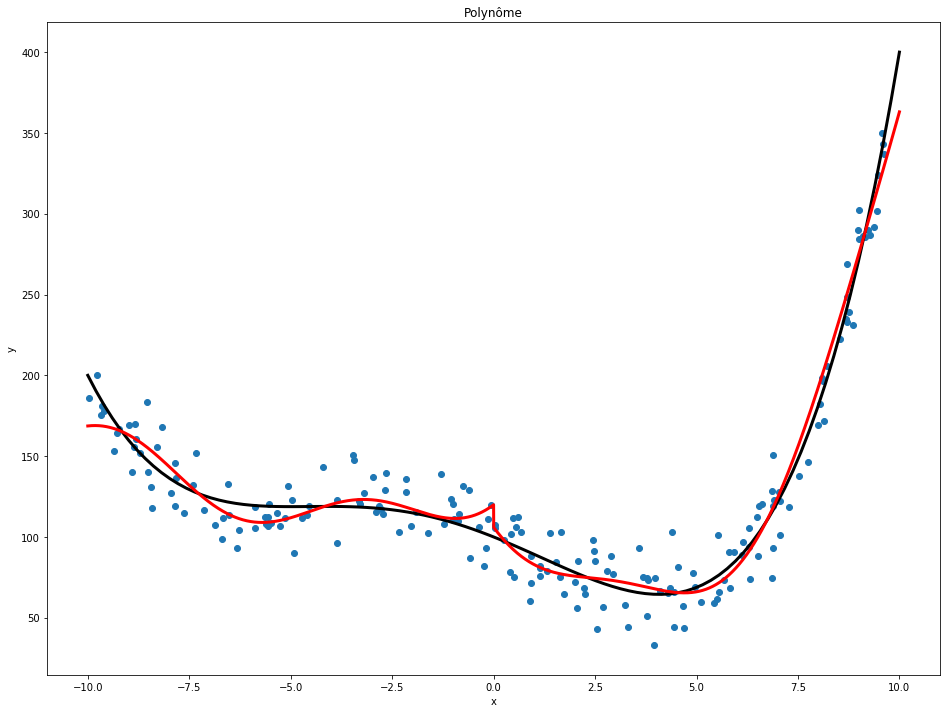

In [31]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(X, y, 'o')
ax.plot(np.linspace(-10,10,100), np.polyval(listeParamPoly,np.linspace(-10,10,100)), color='black', linewidth=3)
ax.set_title('Polynôme')
ax.set_ylabel('y')
ax.set_xlabel('x')

linspace_x = np.linspace(-10, 10, num=100000)
linspace_x = np.expand_dims(linspace_x, axis=1)

linspace_X_augmented = feature_space_projection(linspace_x, phi)

y_pred = reg2.predict(linspace_X_augmented)
ax.plot(linspace_x, y_pred, color='red', linewidth=3)

plt.show()